In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("./dataset/cleaned_news_summary.csv")
data.head()

,Unnamed: 0,text,summary
0,0,administration union territory daman diu revok...,sostok daman diu revokes mandatory rakshabandh...
1,1,malaika arora slammed instagram user trolled d...,sostok malaika slams user who trolled her for ...
2,2,indira gandhi institute medical sciences igims...,sostok virgin now corrected to unmarried in ig...
3,3,lashkaretaibas kashmir commander abu dujana ki...,sostok aaj aapne pakad liya let man dujana bef...
4,4,hotels maharashtra train staff spot signs sex ...,sostok hotel staff to get training to spot sig...


In [3]:
news = data.text
headline = data.summary
news_len = []
headline_len = []
for obj in range(len(news)):
    news_len.append(len(news[obj].split()))
    headline_len.append(len(headline[obj].split()))

In [4]:
max(news_len)

40

Text(0.5, 1.0, 'Distribution of length of news text')

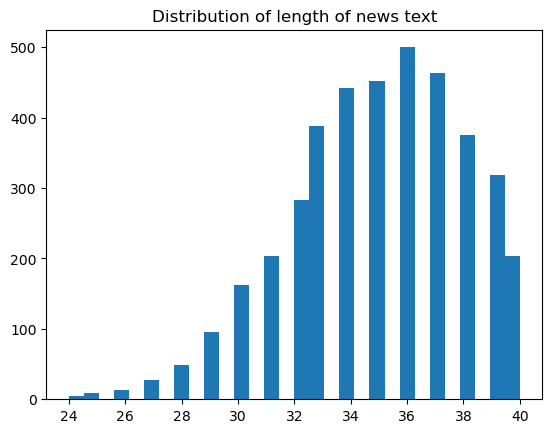

In [5]:
plt.hist(news_len, bins=30)
plt.title("Distribution of length of news text")

Text(0.5, 1.0, 'Distribution of length of headline text')

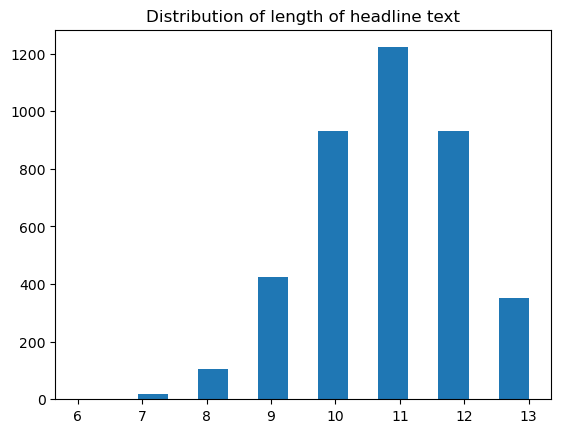

In [6]:
plt.hist(headline_len, bins=15)
plt.title("Distribution of length of headline text")

In [7]:
max_len_news = 40
max_len_headline = 11

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.text, data.summary, test_size=0.2, random_state=101, shuffle=True)

In [37]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention_my import AttentionLayer


import warnings

pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

In [39]:
physical_devices = tf.config.list_physical_devices("GPU")
physical_devices
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]

In [17]:
# x_tokenizer = Tokenizer() 
# x_tokenizer.fit_on_texts(list(X_train))

In [18]:
# thresh=4

# cnt=0
# tot_cnt=0
# freq=0
# tot_freq=0

# for key,value in x_tokenizer.word_counts.items():
#     tot_cnt=tot_cnt+1
#     tot_freq=tot_freq+value
#     if(value<thresh):
#         cnt=cnt+1
#         freq=freq+value
    
# print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
# print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 71.19982331179946
Total Coverage of rare words: 16.813739528889528


In [19]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

X_train_seq = X_tokenizer.texts_to_sequences(X_train)
X_test_seq = X_tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train_seq, maxlen = max_len_news, padding='post')
X_test = pad_sequences(X_test_seq, maxlen = max_len_news, padding='post')

news_vocab_size = len(X_tokenizer.word_index) + 1

In [20]:
# #prepare a tokenizer for reviews on training data
# y_tokenizer = Tokenizer()   
# y_tokenizer.fit_on_texts(list(y_train))

In [21]:
# thresh=6

# cnt=0
# tot_cnt=0
# freq=0
# tot_freq=0

# for key,value in y_tokenizer.word_counts.items():
#     tot_cnt=tot_cnt+1
#     tot_freq=tot_freq+value
#     if(value<thresh):
#         cnt=cnt+1
#         freq=freq+value
    
# print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
# print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 87.87216607484294
Total Coverage of rare words: 31.207617948348005


In [22]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train_seq, maxlen=max_len_headline, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_len_headline, padding='post')
y_voc_size = len(y_tokenizer.word_index) + 1

In [23]:
y_tokenizer.word_counts['eostok'], len(y_train)

(3192, 3192)

In [24]:
from keras import backend as K
K.clear_session()

latent_dim=500

enc_inputs = Input(shape=(max_len_news,))
embedding1 = Embedding(news_vocab_size,latent_dim)(enc_inputs)

lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
enc_output1, h1, c1 = lstm1(embedding1)

lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True)
enc_output2, h2, c2 = lstm2(enc_output1)

lstm3 = LSTM(latent_dim, return_sequences=True,return_state=True)
enc_outputs, h3, c3 = lstm3(enc_output2)


decoder_inputs = Input(shape=(None, ))
dec_embedding = Embedding(y_voc_size, latent_dim)
dec_emb_out = dec_embedding(decoder_inputs)

dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, fwd_state, back_state = dec_lstm(dec_emb_out, initial_state = [h3, c3])



attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_state = attn_layer([enc_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([enc_inputs, decoder_inputs], decoder_outputs)
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 500)      9056000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                              

In [25]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [27]:

history=model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,batch_size=512, callbacks=[es], validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
7/7 [==============================] - 40s 5s/step - loss: 8.2529 - val_loss: 5.6063
Epoch 2/50
7/7 [==============================] - 37s 5s/step - loss: 4.5253 - val_loss: 4.1326
Epoch 3/50
7/7 [==============================] - 34s 5s/step - loss: 4.0815 - val_loss: 3.8242
Epoch 4/50
7/7 [==============================] - 36s 5s/step - loss: 4.0001 - val_loss: 3.7727
Epoch 5/50
7/7 [==============================] - 38s 5s/step - loss: 3.9243 - val_loss: 3.6827
Epoch 6/50
7/7 [==============================] - 39s 6s/step - loss: 3.8861 - val_loss: 3.6816
Epoch 7/50
7/7 [==============================] - 43s 6s/step - loss: 3.8751 - val_loss: 3.6320
Epoch 8/50
7/7 [==============================] - 45s 6s/step - loss: 3.8293 - val_loss: 3.6477
Epoch 9/50
7/7 [==============================] - 44s 6s/step - loss: 3.8123 - val_loss: 3.6170
Epoch 10/50
7/7 [==============================] - 45s 6s/step - loss: 3.7789 - val_loss: 3.6168
Epoch 11/50
7/7 [======================

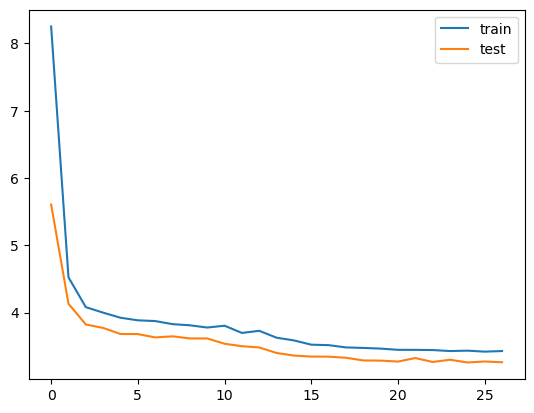

In [28]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()


In [29]:
reverse_target_word_index = y_tokenizer.index_word
reverse_news_words_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [30]:
encoder_model = Model(inputs = enc_inputs, outputs = [enc_outputs, h3, c3])

decoder_h = Input(shape=(latent_dim,))
decoder_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_news, latent_dim))


dec_emb2 = dec_embedding(decoder_inputs)

dec_output2, dec_h2, dec_c2 = dec_lstm(dec_emb2, initial_state=[decoder_h, decoder_c])




attn_out_inf, attn_state_inf = attn_layer([decoder_hidden_state_input, dec_output2])

dec_inf_concat = Concatenate(axis=-1, name='concat')([dec_output2, attn_out_inf])


dec_output2 = decoder_dense(dec_inf_concat)


decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_h, decoder_c], [dec_output2] + [dec_h2, dec_c2])

In [31]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 500)    3661500     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                            

In [32]:
def decode_sequence(input_sequence):
    e_out, e_h, e_c = encoder_model(input_sequence)

    target_seq = np.zeros((1,1))

    target_seq[0,0] = target_word_index['sostok']

    stop_condition = False


    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        sample_token_index = np.argmax(output_tokens[0,-1,:])
        sampled_token = reverse_target_word_index[sample_token_index]

        if sampled_token!='eostok':
            decoded_sentence+= ' ' + sampled_token

        if (sampled_token=='eostok' or len(decoded_sentence.split())>=(max_len_headline-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))

        target_seq[0,0] = target_word_index[sampled_token]


        e_h, e_c = h, c

    return decoded_sentence


In [33]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_news_words_index[i]+' '
    return newString

In [34]:
for i in range(3):
  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_len_news)))
  print("\n")

Review: lowest salary government employee rose 55 last 70 years meanwhile senior government employees salary risen 2000 25 lakh since independence rise seventh pay commission recommended 14 increase basic pay government employees centre 
Original summary: salary of govt over in years 
1/1 [==============================] - 0s 26ms/step
Predicted summary:  to to to


Review: asked plans work us president donald trump uk pm theresa may thursday said sometimes attract share ensure governments working everyone added pm may currently united states expected become first foreign leader meet president trump 
Original summary: uk pm may on working with trump 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  to to to


Review: world bank cleared crore loan making indians governments india mission programme people years age also provision opportunities women increase training 
Original summary: world bank loan to train indian job 
1/1 [==============================] - 0s 2

In [ ]:
reverse_target_word_index

{1: 'start',
 2: 'end',
 3: 'to',
 4: 'in',
 5: 'for',
 6: 'of',
 7: 'on',
 8: 'delhi',
 9: 'at',
 10: 'from',
 11: 'with',
 12: 'after',
 13: 'india',
 14: 'by',
 15: 'over',
 16: 'be',
 17: 'govt',
 18: 'as',
 19: 'not',
 20: 'up',
 21: 'is',
 22: 'man',
 23: 'the',
 24: 'mumbai',
 25: 'bjp',
 26: 'against',
 27: 'will',
 28: 'indian',
 29: 'report',
 30: 'modi',
 31: 'pm',
 32: 'us',
 33: 'was',
 34: 'cr',
 35: 'police',
 36: 'his',
 37: 'crore',
 38: 'woman',
 39: 'film',
 40: 'cm',
 41: 'new',
 42: 'case',
 43: 'arrested',
 44: 'no',
 45: 'lakh',
 46: 'who',
 47: 'it',
 48: 'first',
 49: 'sc',
 50: 'ban',
 51: 'indias',
 52: 'says',
 53: 'people',
 54: 'aap',
 55: 'pak',
 56: 'and',
 57: 'my',
 58: 'get',
 59: 'reports',
 60: 'st',
 61: 'out',
 62: 'women',
 63: 'has',
 64: 'trump',
 65: 'if',
 66: 'attack',
 67: 'years',
 68: 'air',
 69: 'can',
 70: 'kejriwal',
 71: 'have',
 72: 'me',
 73: 'china',
 74: 'hc',
 75: 'gets',
 76: 'jk',
 77: 'her',
 78: 'may',
 79: 'chief',
 80: 'ask

In [74]:
x = np.array([5,4,3,2,1])

In [75]:
np.argmax(x)

0